In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../SourceCode')
import bastien_utils
from shallowAE import ShallowAE
from sparseShallowAE import SparseShallowAE_KL, SparseShallowAE_L1, SparseShallowAE_KL_sum
from nonNegSparseShallowAE import Sparse_NonNeg_ShallowAE_KLsum_AsymDecay
from AsymAE_infoGAN.AsymAE_infoGAN import AsymAEinfoGAN
import datetime
import morphoMaths
import keras
import pandas as pd
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
FILE_PATH = "../"
x_test, _ = bastien_utils.load_data(FILE_PATH, train=False, test=True, subsetTest=False)
x_small = x_test[:10]
print(x_small.shape)

(10, 28, 28, 1)


# 1. Simple

In [5]:
pd.read_csv("../AsymAE_infoGAN/Simple/TestOutputs/18_08_30results")

,Unnamed: 0,SVM_best_C,SVM_best_gamma,SVM_classification_score,dimension,test_error,test_max_approx_error_toOriginal_dilatation,test_max_approx_error_toRec_dilatation,test_sparsity,training_error,training_max_approx_error_toOriginal_dilatation,training_max_approx_error_toRec_dilatation,training_sparsity
0,0,5.994843,0.16681,0.882,100,0.006464,14.313341,14.412237,0.095573,0.006243,14.326369,14.424914,0.096033


Original images and reconstructions


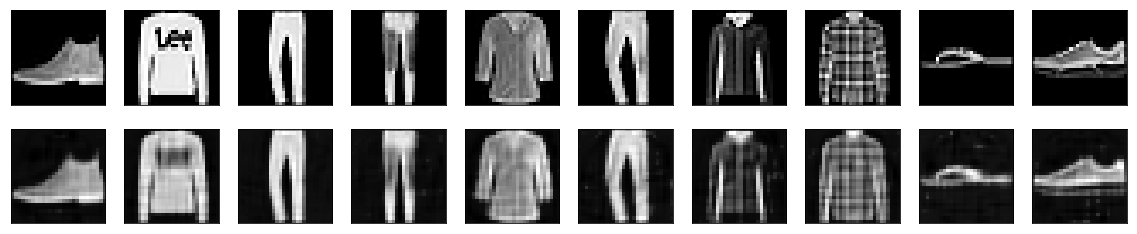

Histograms of encodings


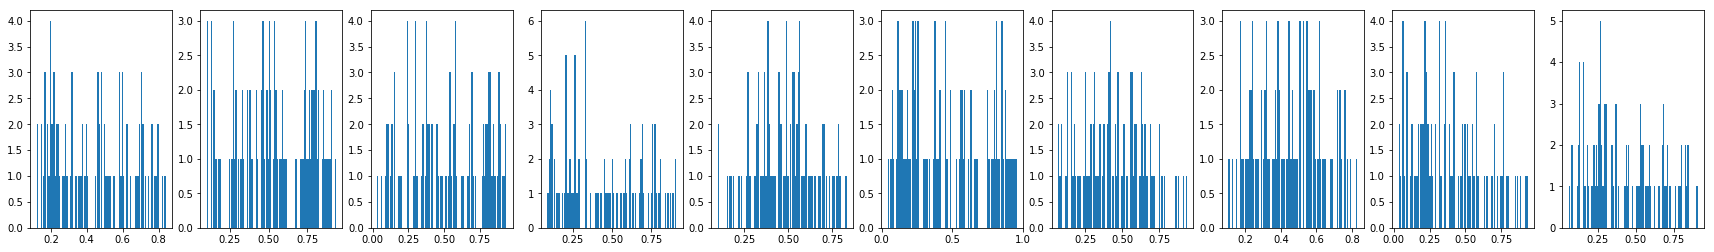

Atom images (weights of the encoder)


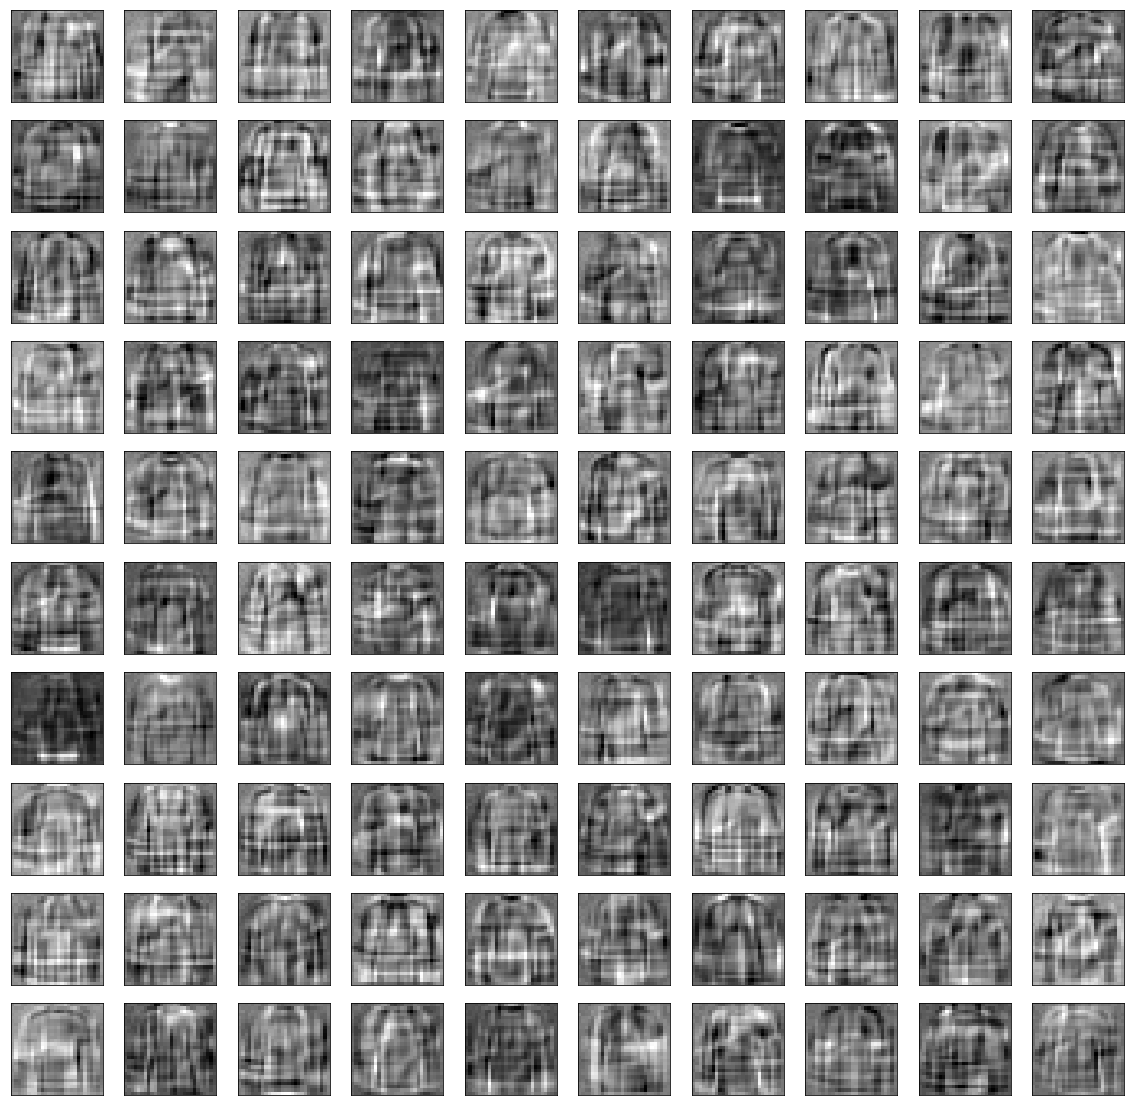

In [6]:
AE = AsymAEinfoGAN.load('18_08_30_dim100.h5')
print('Original images and reconstructions')
AE.plot_reconstructions(x_small)
print('Histograms of encodings')
AE.plot_histograms_of_the_encoding(x_small)
print('Atom images (weights of the encoder)')
AE.plot_atoms_decoder()

Dilatation of original images


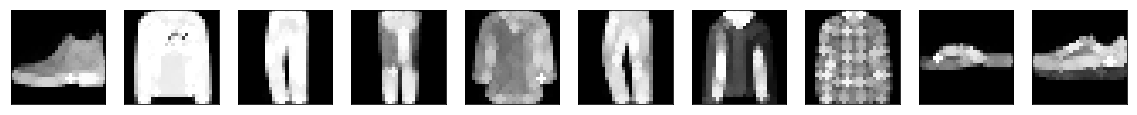

Dilatation of reconstructed images


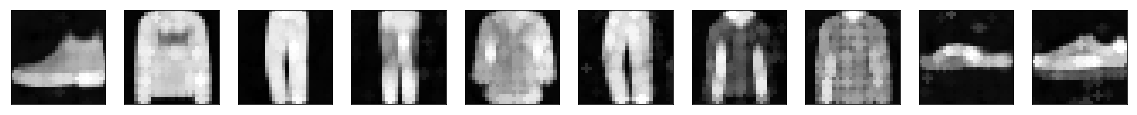

Max-approximation to dilatation


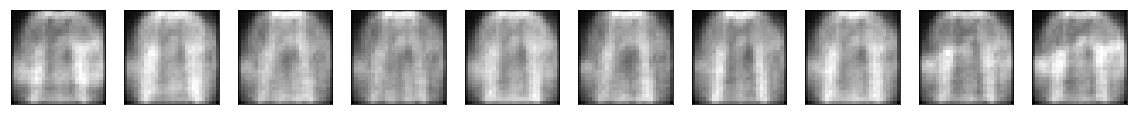

Dilatation of decoder weights


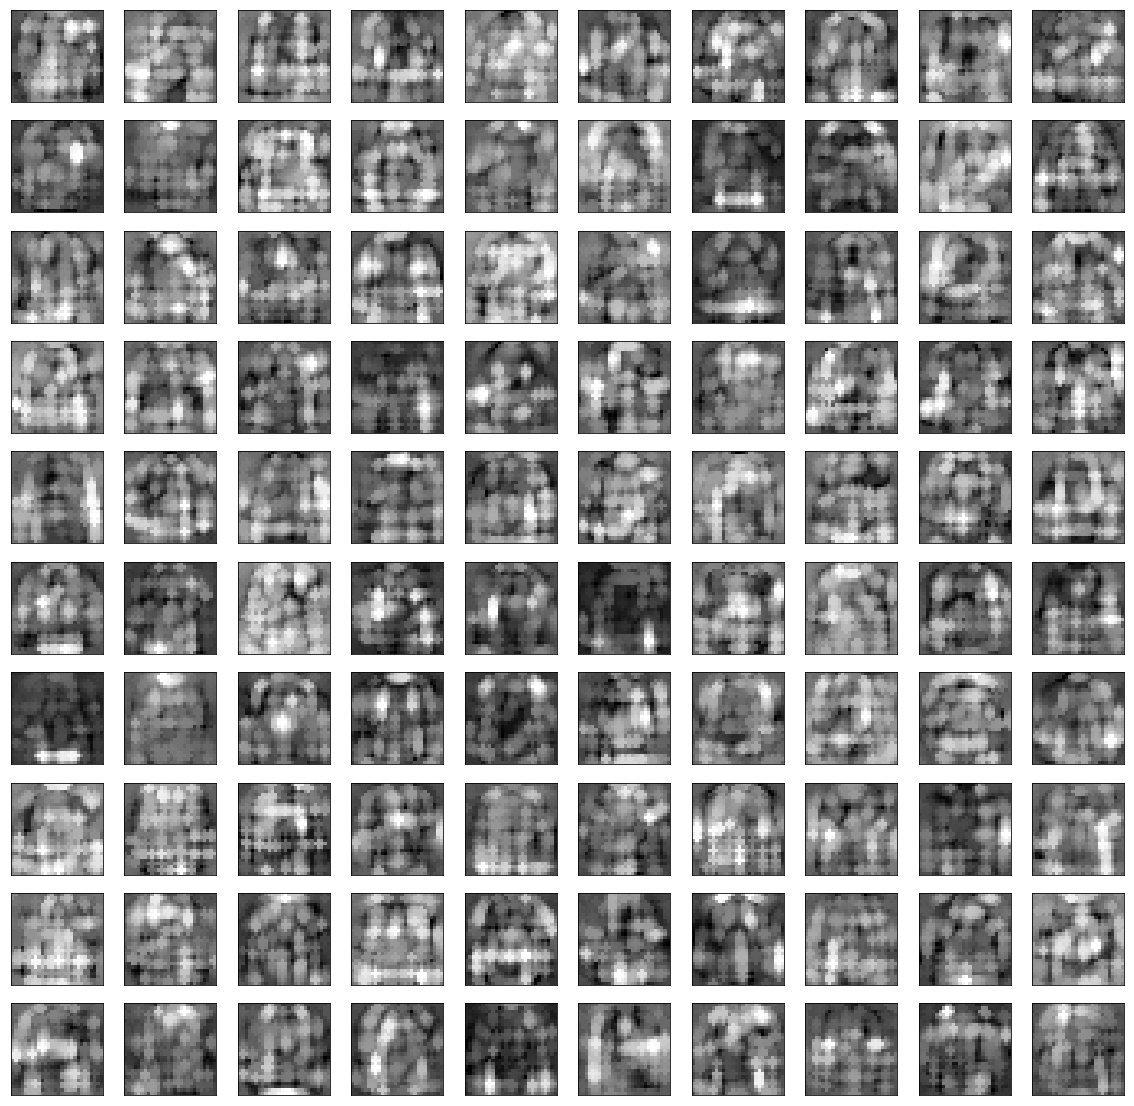

In [8]:
print('Dilatation of original images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, x_small, SE_scale=1))
print('Dilatation of reconstructed images')
bastien_utils.plot_all_images(bastien_utils.apply_operator_to_all_images(morphoMaths.dilatation, AE.reconstruction(x_small), SE_scale=1))
AE_dil = AE.apply_operator_to_decoder_atoms(morphoMaths.dilatation, apply_to_bias=True, SE_scale=1)
print('Max-approximation to dilatation')
AE_dil.plot_reconstructions(x_small, plot_input=False)
print('Dilatation of decoder weights')
AE_dil.plot_atoms_decoder()

In [7]:
x_train, _ = bastien_utils.load_data(FILE_PATH, train=True, test=False, subsetTest=False)
print("Sparsity measure (KL divergence) of train set: ", AE.KL_divergence(x_train, multiply_by_weight_penalty=False, sparsity_objective=0.01))
del x_train
print("Sparsity measure (KL divergence) of test set: ", AE.KL_divergence(x_test, multiply_by_weight_penalty=False, sparsity_objective=0.01))

Sparsity measure (KL divergence) of train set:  59.86934280395508
Sparsity measure (KL divergence) of test set:  59.81623840332031


In [13]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Activation, Conv2D
from keras import losses, regularizers, metrics, constraints
import custom_regularizers

In [14]:
latent_dim = 100
nb_input_channels=1
nb_output_channels=1
nb_rows=28
nb_columns=28
sparsity_weight = 1
sparsity_objective = 0.1
decay_positive_weights = 0        
decay_negative_weights = 1
decay_weight = 1
input_img = Input(shape=( nb_rows,  nb_columns,  nb_input_channels))  # adapt this if using `channels_first` image data format
x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(128, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
encoded = Dense(latent_dim, activation='sigmoid', 
                activity_regularizer=custom_regularizers.KL_divergence(beta= sparsity_weight, 
                                                                rho= sparsity_objective))(x)
encoder = Model(input_img, encoded, name='encoder')
encoded_img = Input(shape=( latent_dim,))  
x = Dense( nb_rows* nb_columns* nb_output_channels, 
    kernel_regularizer=custom_regularizers.asymmetric_weight_decay(alpha= decay_positive_weights, 
                                                                    beta= decay_negative_weights, 
                                                                    lam= decay_weight))(encoded_img)
x = LeakyReLU(alpha=0.1)(x)
decoded = Reshape(( nb_rows, nb_columns, nb_output_channels))(x)
decoder = Model(encoded_img, decoded, name='decoder')
encoded =  encoder(input_img)
decoded =  decoder(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')


In [22]:
encoder =  autoencoder.layers[1]
decoder =  autoencoder.layers[2]
latent_dim =  encoder.output_shape[1]
nb_input_channels =  encoder.input_shape[-1]
nb_output_channels =  decoder.output_shape[-1]
nb_rows =  encoder.input_shape[1]
nb_columns =  encoder.input_shape[2]        
sparsity_weight =  encoder.get_config()['layers'][-1]['config']['activity_regularizer']['config']['beta']
sparsity_objective =  encoder.get_config()['layers'][-1]['config']['activity_regularizer']['config']['rho']
decay_positive_weights =  decoder.get_config()['layers'][1]['config']['kernel_regularizer']['config']['alpha']
decay_negative_weights =  decoder.get_config()['layers'][1]['config']['kernel_regularizer']['config']['beta']
decay_weight =  decoder.get_config()['layers'][1]['config']['kernel_regularizer']['config']['lam']
